# Tumbling Quantification

## Impots

In [157]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits import mplot3d
from scipy.optimize import curve_fit

## Import Video and Extract Boundaries

In [158]:
def extractBoundaries(fileName, blur=5, min_area=500, qc_folder="QC_output"):
    import os
    import cv2
    import numpy as np

    os.makedirs(qc_folder, exist_ok=True)  # make QC folder if missing
    ContoursSeries = []

    cap = cv2.VideoCapture(fileName)
    frame_idx = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Convert to grayscale and blur
        grayImg = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        blurImg = cv2.GaussianBlur(grayImg, (blur, blur), 0)

        # Erode slightly to remove noise
        kernel = np.ones((blur, blur), np.uint8)
        erodeImg = cv2.erode(blurImg, kernel, iterations=1)

        # Otsu threshold
        _, binImg = cv2.threshold(erodeImg, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Morphological close to fill dimmer spots inside the nucleus
        kernel2 = np.ones((5, 5), np.uint8)
        binImg = cv2.morphologyEx(binImg, cv2.MORPH_CLOSE, kernel2)

        # Find contours
        contours, hierarchy = cv2.findContours(binImg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

        # Filter by minimum area and keep only the largest
        contours = [c for c in contours if cv2.contourArea(c) > min_area]
        if contours:
            contours = [max(contours, key=cv2.contourArea)]  # keep only the largest

        ContoursSeries.append(contours)

        # QC overlay
        overlay = cv2.cvtColor(grayImg, cv2.COLOR_GRAY2BGR)
        if contours:
            cv2.drawContours(overlay, contours, -1, (0, 255, 0), 2)

        save_path = os.path.join(qc_folder, f"frame_{frame_idx:04d}.png")
        cv2.imwrite(save_path, overlay)

        # Optional live preview
        combined = np.concatenate((overlay, cv2.cvtColor(binImg, cv2.COLOR_GRAY2BGR)), axis=1)
        cv2.imshow("QC", combined)
        if cv2.waitKey(50) & 0xFF == ord('q'):
            break

        frame_idx += 1

    cap.release()
    cv2.destroyAllWindows()
    cv2.waitKey(1)

    return ContoursSeries



## Rotated Ellipse Equation

In [159]:
def rotatedEllipse(X, a, b, theta):
    x, y = X
    result = ((1/b * np.sin(theta))**2 + (1/a * np.cos(theta))**2) * x**2 + 2 * ((1/a)**2 - (1/b)**2) * np.sin(theta) * np.cos(theta) * x * y + ((1/b * np.cos(theta))**2 + (1/a * np.sin(theta))**2) * y**2
    return result

## Calculate Params Over All Frames and Rate of Change

In [160]:
def ellipseFit(ContoursSeries):
    xCents = []
    yCents = []
    aVals = []
    bVals = []
    thetaVals = []
    xValsAll = []
    yValsAll = []

    for boundaries in ContoursSeries:
        if len(boundaries) == 0:
            # No contour found in this frame
            xCents.append(np.nan)
            yCents.append(np.nan)
            aVals.append(np.nan)
            bVals.append(np.nan)
            thetaVals.append(np.nan)
        else:
            # Only one contour per frame now
            cellBound = boundaries[0]
            xvals = np.asarray([pair[0][0] for pair in cellBound])
            yvals = np.asarray([pair[0][1] for pair in cellBound])
            xValsAll.append(xvals)
            yValsAll.append(yvals)

            # Calculate centroid
            xcent = np.mean(xvals)
            ycent = np.mean(yvals)
            xCents.append(xcent)
            yCents.append(ycent)

            # Prepare data for ellipse fitting
            X = (xvals - xcent, yvals - ycent)
            ones = np.ones(len(xvals))

            # Fit rotated ellipse
            params, cov = curve_fit(
                rotatedEllipse, X, ones, bounds=(0, [np.inf, np.inf, np.pi]), method='trf'
            )
            aVals.append(params[0])
            bVals.append(params[1])
            thetaVals.append(params[2])

    return xCents, yCents, aVals, bVals, thetaVals, xValsAll, yValsAll


In [161]:
def findDistancesCoords(xCoords, yCoords):
    diffs = []
    x1 = xCoords[0]
    y1 = yCoords[0]
    for i in range(len(xCoords) - 1):
        x2 = xCoords[i + 1]
        y2 = yCoords[i + 1]
        if x2 != np.nan:
            diff = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
            diffs.append(diff)
            x1 = x2
            y1 = y2
    return diffs

In [162]:
def avLinVel(xCoords, yCoords, timeGap):
    diffs = findDistancesCoords(xCoords, yCoords)
    return np.nanmean(np.absolute(diffs)) / timeGap

In [163]:
def fixThetas(aVals, bVals, thetaVals):
    thetaNew = []
    halfCirc = np.pi / 2
    for i in range(len(thetaVals)):
        if aVals[i] >= bVals[i]:
            thetaNew.append(thetaVals[i])
        else: 
            # Case where minor axis in second quad
            if thetaVals[i] >= halfCirc:
                thetaNew.append(thetaVals[i] - halfCirc)
            # Case where minor axis first quad
            else: 
                thetaNew.append(thetaVals[i] + halfCirc)
    return thetaNew 

In [164]:
def findDifference(vals):
    diffs = []
    first = vals[0]
    for i in range(len(vals) - 1):
        second = vals[i + 1]
        if second != np.nan:
            # Assumption here is that rotation from frame to frame take min path 
            diff = min(abs(second - first), abs((second - np.pi) - first), abs(second - (np.pi - first)))
            diffs.append(diff)
            first = second
    return diffs

In [165]:
def avAngularVel(vals, timeGap):
    diffs = findDifference(vals)
    return np.nanmean(np.absolute(diffs)) / timeGap

## Visualize the Fit for the Ellipses

In [166]:
def visualizeEllipse(fileName, ContoursSeries, xCents, yCents, aVals, bVals, thetaVals):
    
    cap = cv2.VideoCapture(fileName)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    
    i = 0

    # Make object to save the video
#     saveName = 'Modified.avi'  # change the file name if needed
#     imgSize = (height, width)
#     frame_per_second = fps
#     writer = cv2.VideoWriter(saveName, cv2.VideoWriter_fourcc('M','J','P','G'), frame_per_second, imgSize)
    
    # Loop through all frames
    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret==True:
            
            # Convert color to gray, remove timer/scale bar, erode, binarize, save
            grayImg = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            kernel = np.ones((13,13), np.uint8)
            blurImg = cv2.GaussianBlur(grayImg,(13,13),0)
            erodeImg = cv2.erode(blurImg, kernel, iterations=1)
            ret, binImg = cv2.threshold(erodeImg,0,255,cv2.THRESH_BINARY + cv2.THRESH_OTSU)

            # Display original and binarized with contours + ellipse fit
            binImgColor = cv2.cvtColor(binImg,cv2.COLOR_GRAY2RGB)
            cv2.drawContours(binImgColor, ContoursSeries[i], -1, (0,255,0), 0)
            if not np.isnan(xCents[i]):
                binImgColor = cv2.circle(binImgColor, (int(xCents[i]), int(yCents[i])), 5, (0,255,0), -1)
                binImgColor = cv2.ellipse(binImgColor, (int(xCents[i]), int(yCents[i])), (int(aVals[i]), int(bVals[i])), thetaVals[i] * 180 / np.pi, 0, 360, (255, 0, 0), 2)
                if aVals[i] >= bVals[i]:
                    binImgColor = cv2.line(binImgColor, (int(xCents[i] + aVals[i] * np.cos(thetaVals[i])), int(yCents[i] + aVals[i] * np.sin(thetaVals[i]))), (int(xCents[i] - aVals[i] * np.cos(thetaVals[i])), int(yCents[i] - aVals[i] * np.sin(thetaVals[i]))), (0, 0, 255), 2)
                else:
                    thetaValsNew = fixThetas([aVals[i]], [bVals[i]], [thetaVals[i]])
                    binImgColor = cv2.line(binImgColor, (int(xCents[i] + bVals[i] * np.cos(thetaValsNew[0])), int(yCents[i] + bVals[i] * np.sin(thetaValsNew[0]))), (int(xCents[i] - bVals[i] * np.cos(thetaValsNew[0])), int(yCents[i] - bVals[i] * np.sin(thetaValsNew[0]))), (0, 0, 255), 2)
                # print(aVals[i], bVals[i], thetaVals[i])
            combined = np.concatenate((frame, binImgColor), axis = 1)
#             writer.write(frame)
            cv2.imshow('frame',combined)
            
            # Move to next values in list
            i += 1
            
            if cv2.waitKey(50) & 0xFF == ord('q'):
                break
        else:
            break
    cap.release()
    cv2.destroyAllWindows()
#     writer.release()
    cv2.waitKey(1)
    
    return


## Visualize all Boundary Positions

In [167]:
def allBoundaries(video, xValsAll, yValsAll):
    fig = plt.figure(figsize=(6, 6))
    size = len(xValsAll)
    cmap = plt.get_cmap('rainbow')
    for i in range(len(xValsAll)):
        # Change to rainbow color
        plt.plot(xValsAll[i], yValsAll[i], ls='-', color = cmap(i / size))
        plt.title(video[:-4])
        plt.axis('off')
        plt.savefig("Tumbling/Figures/" + video[:-4] + ".png", dpi = 300)
    return 

## Main Function

In [168]:
def mainFunction(path, videos):
    blur = 13
    avLinVels = []
    avAngVels = []
    for video in videos:
        if '.avi' in video and 'Modified' not in video:
            print(video)
            filename = path + '/' + video
            ContoursSeries = extractBoundaries(filename, blur)
            xCents, yCents, aVals, bVals, thetaVals, xValsAll, yValsAll = ellipseFit(ContoursSeries)
            fixedThetas = fixThetas(aVals, bVals, thetaVals)
            LinVel = avLinVel(xCents, yCents, 5)
            AngVel = avAngularVel(fixedThetas, 5)
            avLinVels.append(LinVel)
            avAngVels.append(AngVel)
            visualizeEllipse(filename, ContoursSeries, xCents, yCents, aVals, bVals, thetaVals)
            allBoundaries(video, xValsAll, yValsAll)
    return avLinVels, avAngVels

## Project Data

### Chondrogenesis Fast and SG Day 1

fast_gel1_01_01.avi
fast_gel1_01_02.avi
fast_gel1_01_03.avi
fast_gel1_01_04.avi
fast_gel1_01_05.avi
fast_gel2_01_01.avi
fast_gel2_01_02.avi
fast_gel2_01_03.avi
fast_gel2_01_05.avi
fast_gel2_01_06.avi
fast_gel2_01_07.avi
fast_gel3_01_01.avi
fast_gel3_01_02.avi
fast_gel3_01_03.avi
fast_gel3_01_04.avi
fast_gel3_01_05.avi
fast_gel3_01_06.avi
fast_gel3_01_07.avi


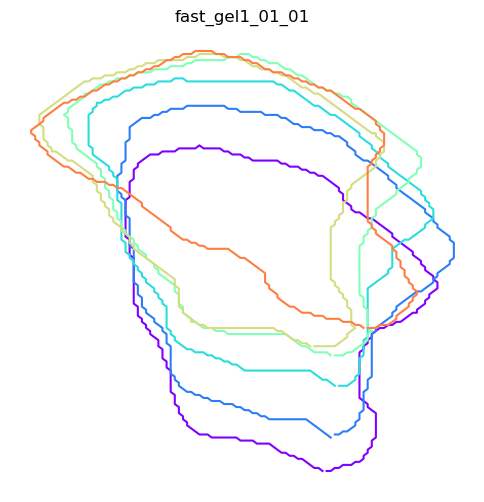

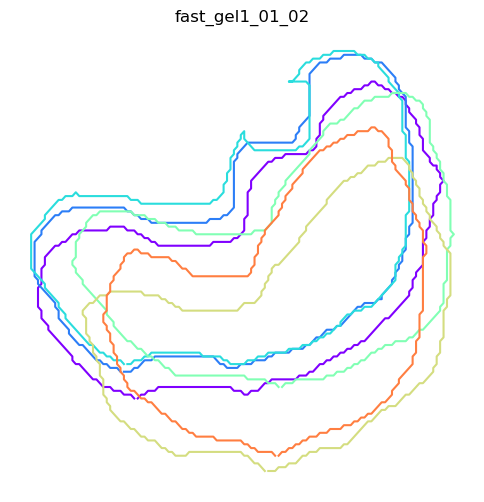

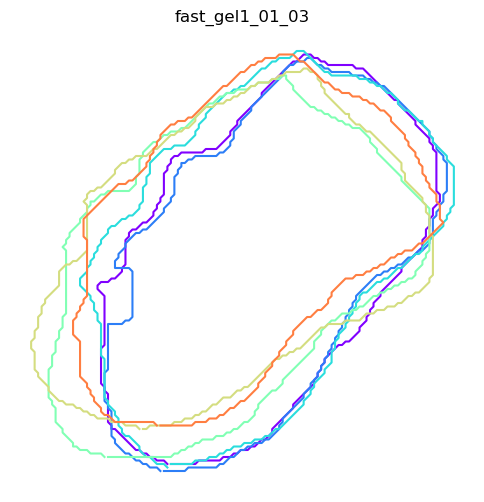

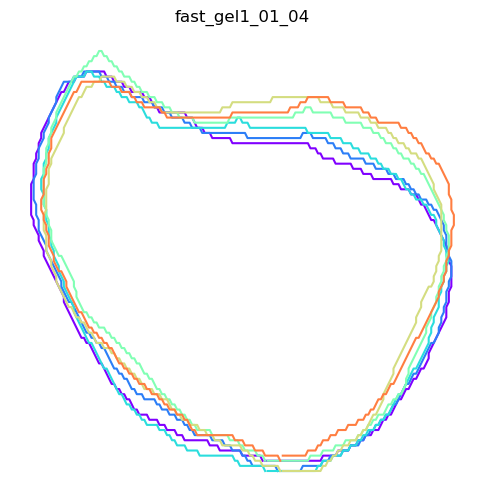

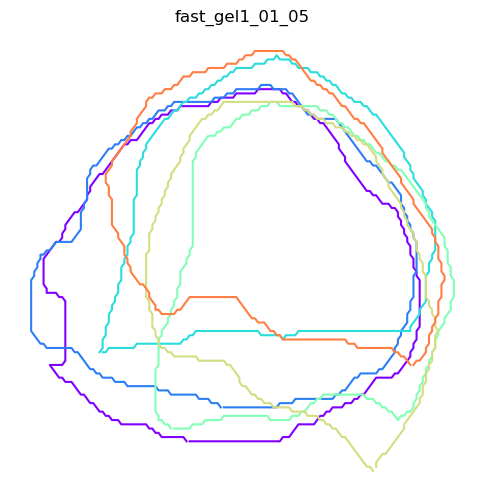

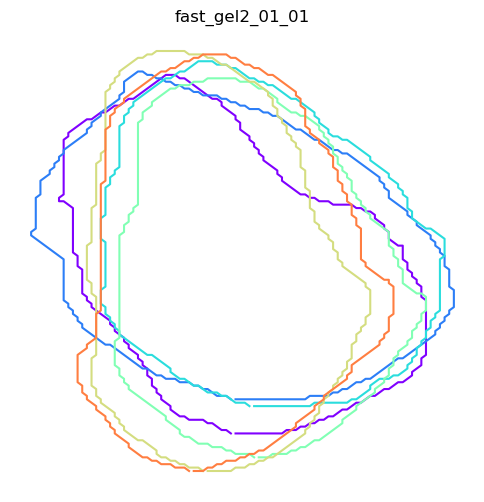

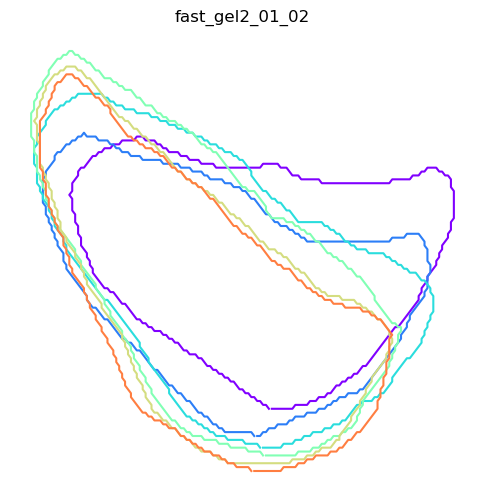

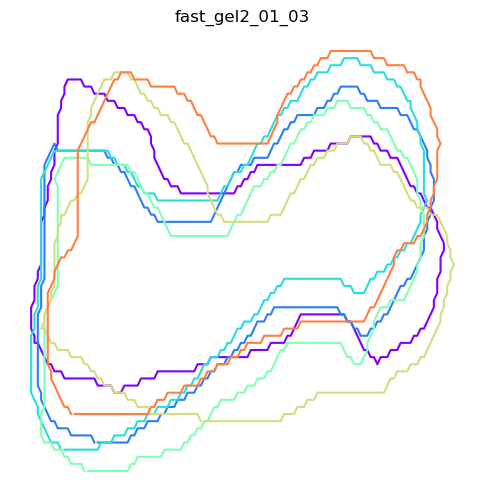

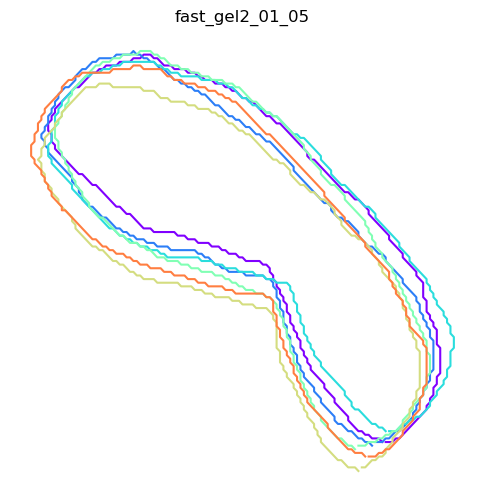

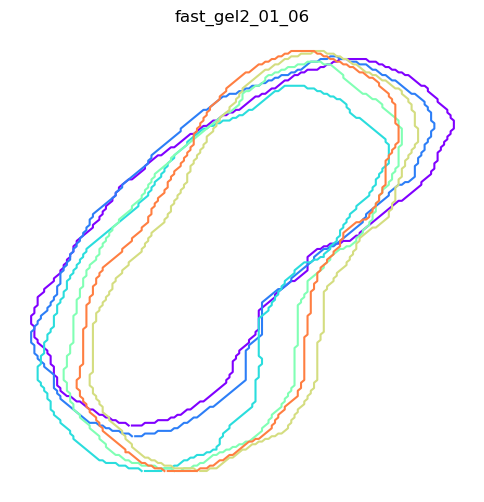

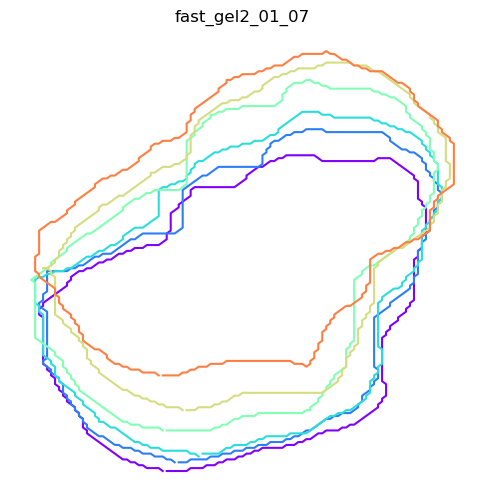

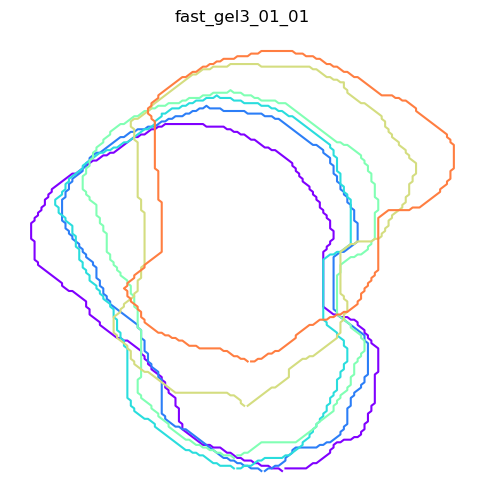

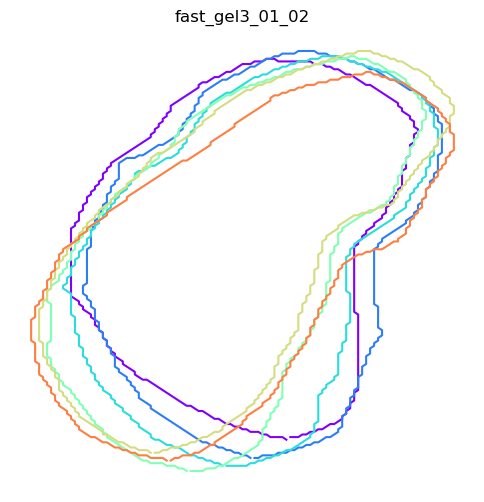

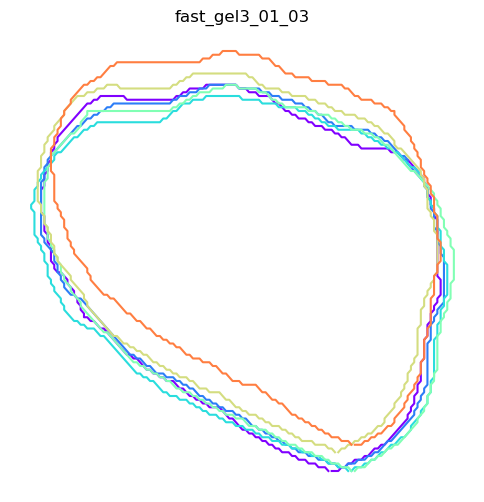

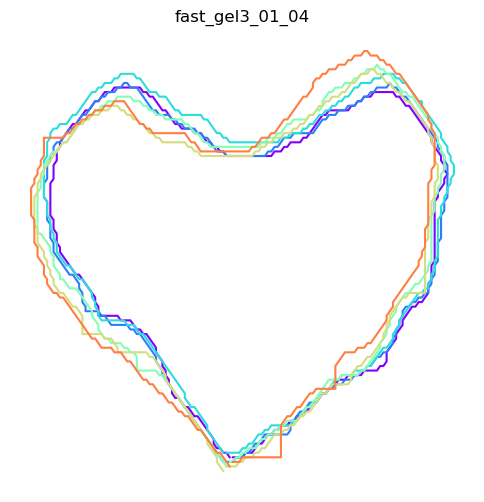

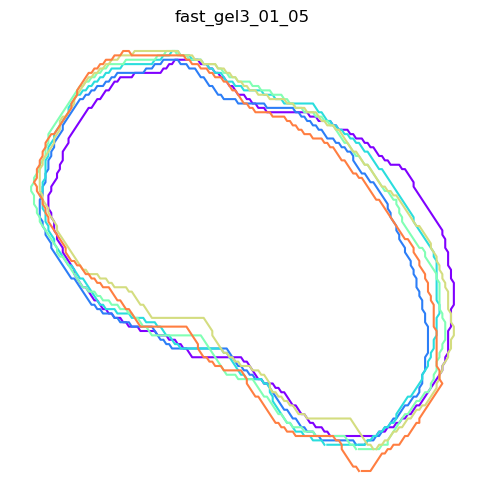

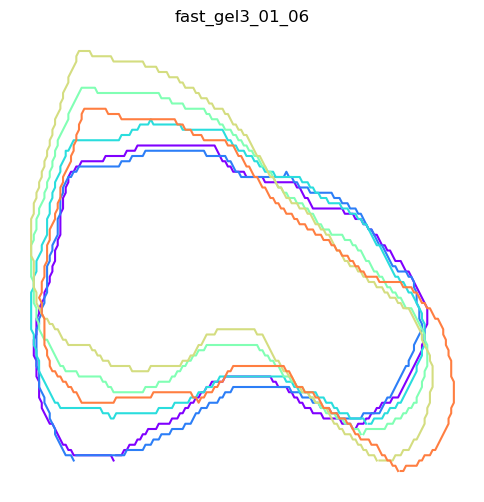

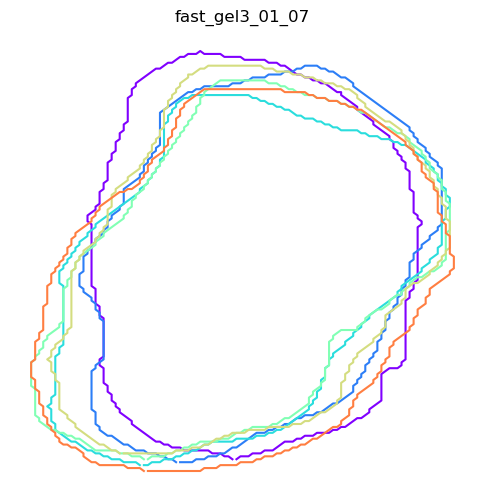

In [176]:
# Fast
path = ""
images = os.listdir(path)
images.sort()
avLinVelsFast_D1_Chondro, avAngVelsFast_D1_Chondro = mainFunction(path, images)

sg_gel1_01_01.avi
sg_gel1_01_02.avi
sg_gel1_01_03.avi
sg_gel1_01_04.avi
sg_gel1_01_06.avi
sg_gel2_01_01.avi
sg_gel2_01_02.avi
sg_gel2_01_03.avi
sg_gel2_01_04.avi
sg_gel2_01_05.avi
sg_gel2_01_06.avi
sg_gel2_01_07.avi
sg_gel3_01_01.avi
sg_gel3_01_02.avi
sg_gel3_01_03.avi
sg_gel3_01_04.avi
sg_gel3_01_05.avi
sg_gel3_01_06.avi


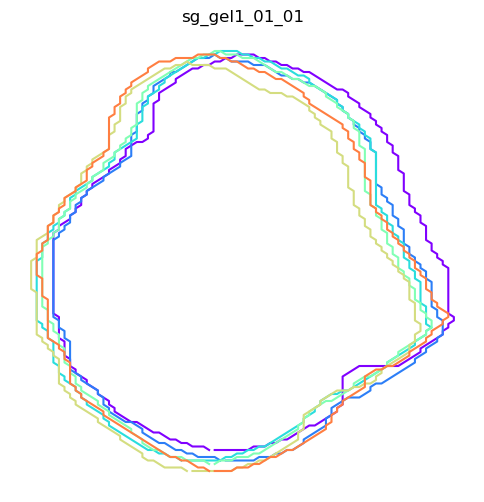

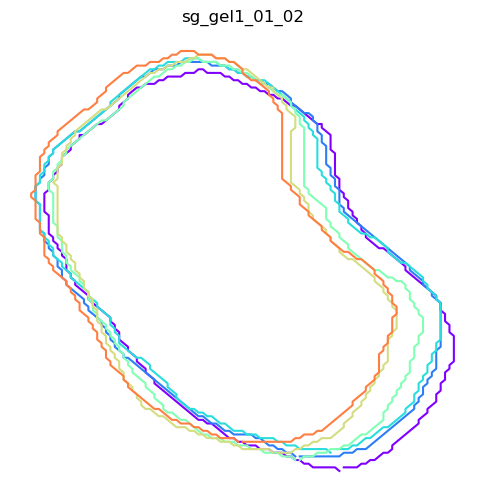

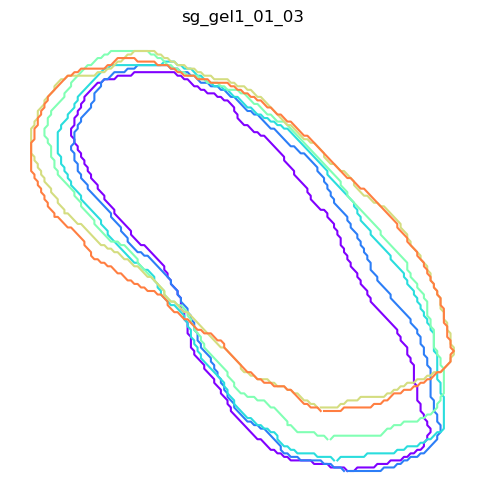

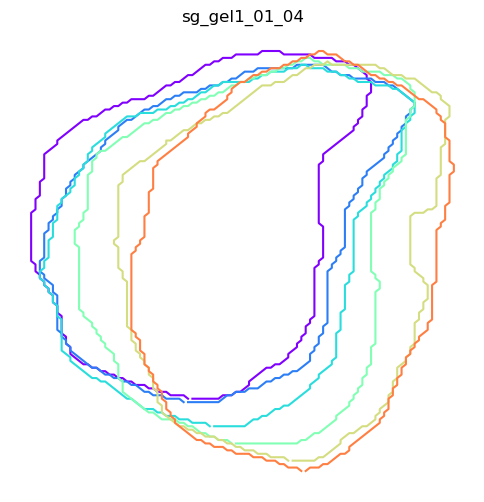

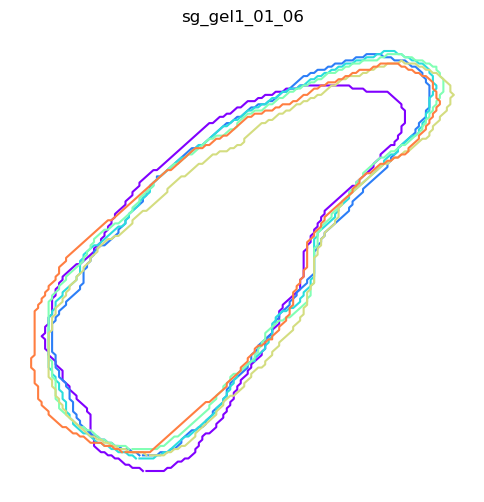

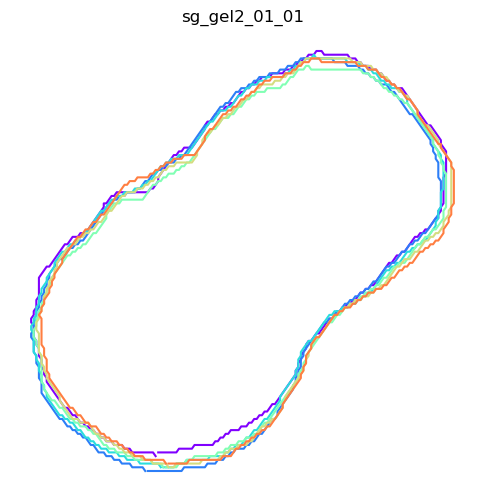

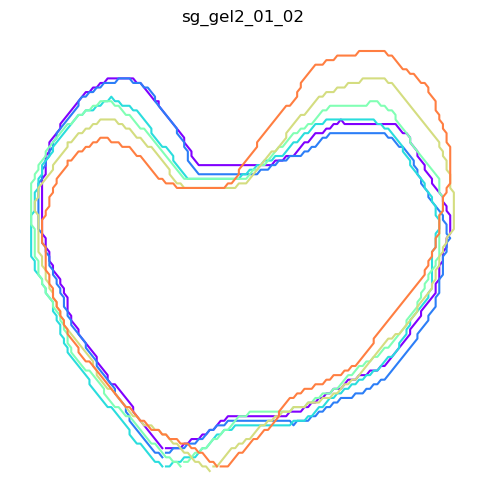

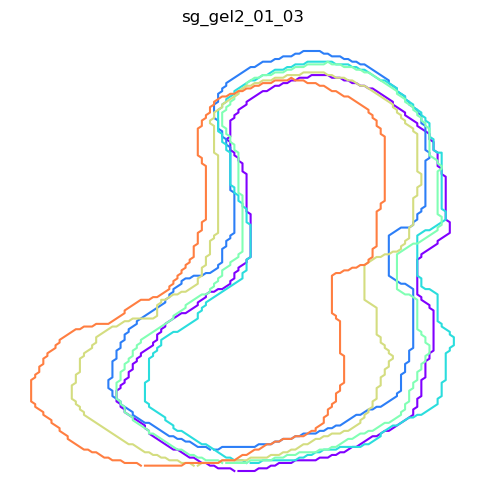

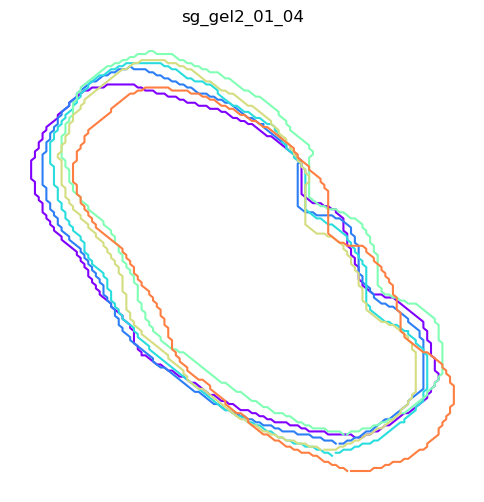

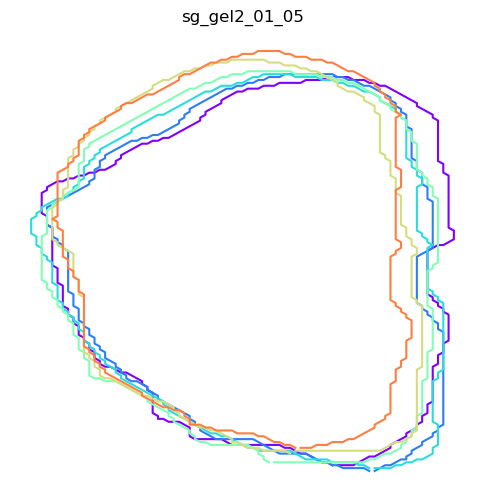

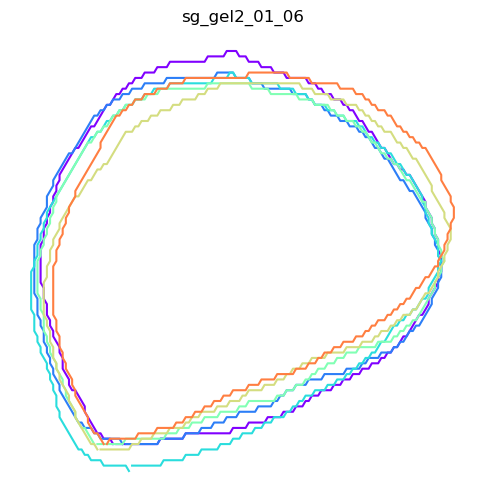

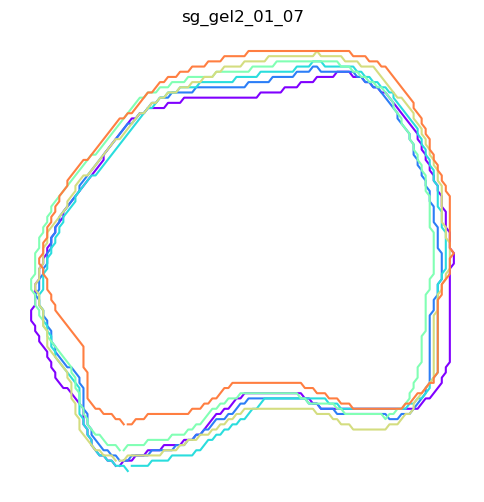

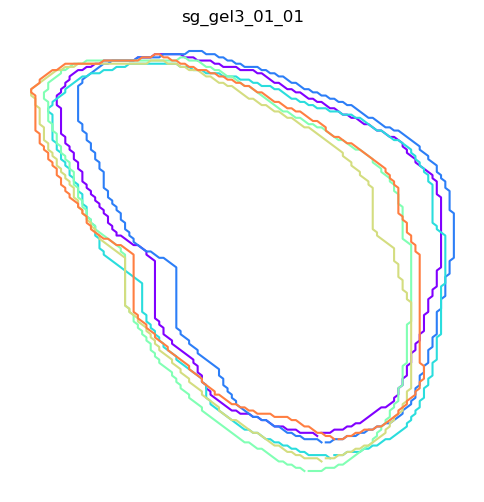

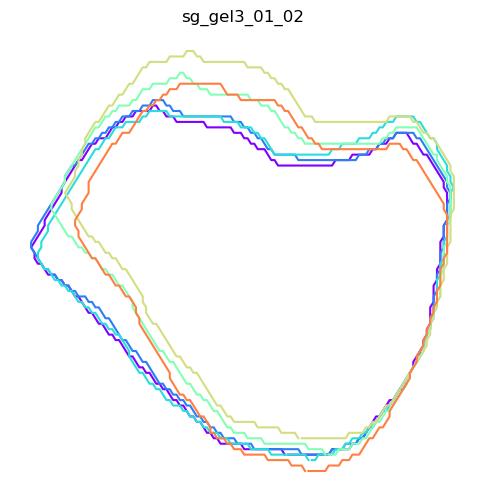

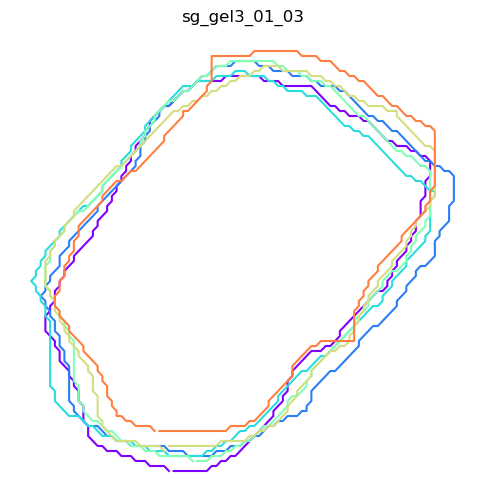

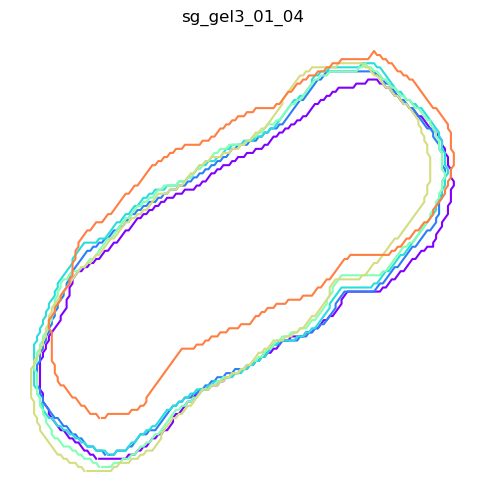

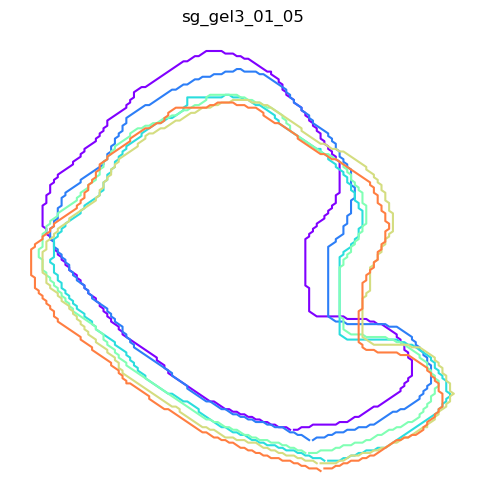

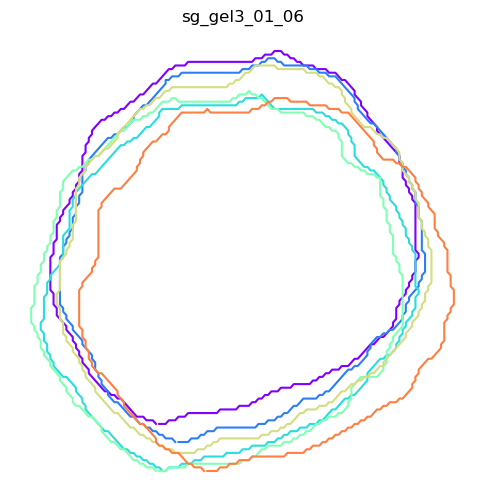

In [177]:
# SG
path = ""
images = os.listdir(path)
images.sort()
avLinVelsSG_D1_Chondro, avAngVelsSG_D1_Chondro = mainFunction(path, images)

### Combine All Data

In [179]:
# Chondro Fast Day 1 
data = {'avLinVelsFast_D1_Chondro': avLinVelsFast_D1_Chondro, 'avAngVelsFast_D1_Chondro': avAngVelsFast_D1_Chondro}
df_Fast_D1_Chondro = pd.DataFrame(data)
# Chondro CG Day 0 
data = {'avLinVelsSG_D1_Chondro': avLinVelsSG_D1_Chondro, 'avAngVelsSG_D1_Chondro': avAngVelsSG_D1_Chondro}
df_SG_D1_Chondro = pd.DataFrame(data)

# Combine All data
allData = pd.concat([df_Fast_D1_Chondro, df_SG_D1_Chondro], axis=1)
allData.to_csv("Tumbling/Final Data/allData.csv")

In [180]:
allData

,avLinVelsFast_D1_Chondro,avAngVelsFast_D1_Chondro,avLinVelsSG_D1_Chondro,avAngVelsSG_D1_Chondro
0,1.894999,0.022703,0.449169,0.009192
1,2.057315,0.013784,0.494408,0.012585
2,1.032827,0.021684,0.680827,0.012703
3,0.324452,0.005157,1.019699,0.018855
4,2.094428,0.028830,0.646027,0.005646
5,1.202614,0.037177,0.359754,0.003350
6,1.227752,0.022553,0.454575,0.018768
7,0.898629,0.017460,1.427974,0.012351
8,0.862168,0.009242,0.964536,0.010062
9,1.535691,0.013270,0.463449,0.012705
